In [54]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils import data
import os
from os import listdir
from os.path import join, abspath
import itertools
import re
import random
import time
from torch.autograd import Variable
from scipy.signal import tukey
from torch.utils import data
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings("ignore")


import json
import sqlalchemy as sal
import getpass
import pandas as pd
from urllib.request import urlopen
import pickle as pkl

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Read Saved Data

In [55]:
# filename = '../data_traffic/traffic_bayArea_station_mediumSize_12pts.pkl'
# filename = '../data_traffic/traffic_bayArea_station_400001.pkl'
# filename = '../data_traffic/traffic_bayArea_station_allStations_12pts_withNaNs.pkl'
filename = r'C:\Users\rmartinez4\Box\Personal Git\dse-capstone\seq2seq_example\data_traffic\traffic_bayArea_station_allStations_12pts_SPEED.pkl'


In [56]:
%%time

# read tensor
with open(filename, "rb") as fout:
    c_time_series = pkl.load(fout)

Wall time: 4.14 s


In [57]:
c_time_series.shape

torch.Size([16618280, 24, 1])

# Generate Train and Test Datasets

In [58]:
def scale_data(data_x, data_y, out_pos = 0, return_current_avg_std = False):
    """ 
    Arg:
        data_x: features
        data_y: labels
        out_pos: the position of feature of which average and stand deviation will be returned.
    returns:
        1. Normalized features and labels
        2. Average and standard deviation of the selected feature.
    """
    avg = data_x[:,:,out_pos].mean()
    std = data_x[:,:,out_pos].std()
#     c_avg = data_x[:,:,1].mean()
#     c_std = data_x[:,:,1].std()
    for i in range(data_x.shape[-1]):
        data_x[:,:,i] = (data_x[:,:,i] - data_x[:,:,i].mean())/data_x[:,:,i].std()
    data_y = (data_y-avg)/std
    if return_current_avg_std:
        return data_x, data_y, (avg, std)  
#         return data_x, data_y, (avg, std), (c_avg, c_std)   
    else:
        return data_x, data_y, (avg, std)

class Dataset(data.Dataset):
    def __init__(self, X, Y, lst_index, output_steps, position_embedding = (False)):
        """
        Args:
            lst_index: indexes of observations in the dataset.
            output_steps: Forecasting Horizon.
        """
        self.X = X[lst_index]
        self.Y = Y[lst_index]
        self.output_steps = output_steps
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index][:self.output_steps]
        return x, y

In [59]:
%%time

sample_size = c_time_series.shape[0]
segment_size = c_time_series.shape[1]
pred_size = int(segment_size/2)

test_size = sample_size // 4
train_valid_size = test_size * 3
training_size = test_size * 2
validation_size = test_size * 1

# X_train = c_time_series[:train_valid_size,:pred_size,:]
# Y_train = c_time_series[:train_valid_size,pred_size:,:]
# sample_size, pred_length, feature_count = X_train.shape

X_test = c_time_series[training_size:training_size+test_size,:pred_size,:]
Y_test = c_time_series[training_size:training_size+test_size,pred_size:,:]

X_all = c_time_series[:train_valid_size+test_size,:pred_size,:]
Y_all = c_time_series[:train_valid_size+test_size,pred_size:,:]

X, Y, (avg, std) = scale_data(X_all, Y_all, out_pos = 0, return_current_avg_std = True)

Wall time: 5.96 s


In [49]:
c_time_series.mean()

tensor(32.1778, dtype=torch.float64)

In [50]:
X_all.mean()

# data_x[:,:,i].std()

tensor(5.3758e-13, dtype=torch.float64)

In [60]:
avg

tensor(64.3560, dtype=torch.float64)

In [61]:
std

tensor(7.2992, dtype=torch.float64)

In [19]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_all.shape, Y_all.shape)

# print(sample_size, pred_length, feature_count)

print(test_size, train_valid_size, training_size, validation_size)

NameError: name 'X_train' is not defined

In [20]:
Y[3]

tensor([[0.9102],
        [0.8691],
        [0.9650],
        [0.9787],
        [0.9513],
        [0.9787],
        [0.9376],
        [0.9102],
        [0.8691],
        [0.8417],
        [0.8417],
        [0.8554]], dtype=torch.float64)

# Train Neural Network

In [21]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        """
        Args:
            input_dim: the dimension of input sequences.
            hidden_dim: number hidden units.
            num_layers: number of encode layers.
            dropout_rate: recurrent dropout rate.
        """
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional = True, dropout = dropout_rate, batch_first = True)
        
    def forward(self, source):
        """
        Args:
            source: input tensor(batch_size*input dimension)
        Return:
            outputs: Prediction
            concat_hidden: hidden states
        """
        outputs, hidden = self.lstm(source)
        return outputs, hidden
    
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate):
        """
        Args:
            output_dim: the dimension of output sequences.
            hidden_dim: number hidden units.
            num_layers: number of code layers.
            dropout_rate: recurrent dropout rate.
        """
        super(Decoder, self).__init__()
        
        # Since the encoder is bidirectional, decoder has double hidden size
        self.lstm = nn.LSTM(output_dim, hidden_dim*2, num_layers = num_layers, 
                            dropout = dropout_rate, batch_first = True)
        
        self.out = nn.Linear(hidden_dim*2, output_dim)
      
    def forward(self, x, hidden):
        """
        Args:
            x: prediction from previous prediction.
            hidden: hidden states from previous cell.
        Returns:
            1. prediction for current step.
            2. hidden state pass to next cell.
        """
        output, hidden = self.lstm(x, hidden)   
        prediction = self.out(output.float())
        return prediction, hidden     
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        """
        Args:
            encoder: Encoder object.
            decoder: Decoder object.
            device: 
        """
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target_tensor):
        """
        Args:
            source: input tensor.
            target_length: forecasting steps.
        Returns:
            total prediction
        """
        batch_size = source.size(0) 
        input_length = source.size(1) 
        target_length = target_tensor.shape[1]
        output_dim = target_tensor.shape[-1]
        encoder_hidden = (torch.zeros(self.encoder.num_layers*2, batch_size, self.encoder.hidden_dim, device=device),
                          torch.zeros(self.encoder.num_layers*2, batch_size, self.encoder.hidden_dim, device=device))
        encoder_output, encoder_hidden = self.encoder(source)
        
        # Concatenate the hidden states of both directions.
        num_layers = int(encoder_hidden[0].shape[0]/2)
        h = torch.cat([encoder_hidden[0][0:self.encoder.num_layers,:,:], 
                       encoder_hidden[0][-self.encoder.num_layers:,:,:]], 
                      dim=2, out=None).to(device)
        c = torch.cat([encoder_hidden[1][0:self.encoder.num_layers,:,:], 
                       encoder_hidden[1][-self.encoder.num_layers:,:,:]], 
                      dim=2, out=None).to(device)
        concat_hidden = (h, c)
        
        
        outputs = torch.zeros(batch_size, target_length, output_dim).to(self.device)
        decoder_output = torch.zeros((batch_size, 1, output_dim), device = self.device)
        decoder_hidden = concat_hidden
        
        for t in range(target_length):  
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden)
            outputs[:,t:t+1,:] = decoder_output
        return outputs

In [22]:
def run_epoch_train(model, data_generator, model_optimizer, criterion):
    """
    Args:
        model: RNN model.
        data_generator: data.DataLoader object.
        model_optimizer: optimizer.
        criterion: loss function
    Returns:
        Root Mean Square Error on Training Dataset
    """
    MSE = []
    for x, y in data_generator:
        # The input shape for nn.conv1d should sequence_length * batch_size * #features
        input_tensor, target_tensor = x.to(device).float(), y.to(device).float()
        model_optimizer.zero_grad()
        loss = 0
        output = model(input_tensor, target_tensor).reshape(target_tensor.shape)
        num_iter = output.size(0)
        for ot in range(num_iter):
            loss += criterion(output[ot], target_tensor[ot])
        MSE.append(loss.item()/num_iter)
        loss.backward()
        model_optimizer.step()
    
    return round(np.sqrt(np.mean(MSE)), 5)
 

def run_epoch_eval(model, data_generator, criterion, return_pred = False):
    """
    Args:
        model: CNN model.
        data_generator: data.DataLoader object.
        criterion: loss function
    Returns:
        Root Mean Square Error on evaluation datasets.
    """
    with torch.no_grad():
        MSE = []
        preds = []
        for x, y in data_generator:
            input_tensor, target_tensor = x.to(device).float(), y.to(device).float()
            loss = 0
            output = model(input_tensor, target_tensor).reshape(target_tensor.shape)
            
            preds.append(output.cpu().detach().numpy())
            num_iter = output.size(0)
            
            for ot in range(num_iter):
                loss += criterion(output[ot], target_tensor[ot])
            MSE.append(loss.item()/num_iter)
            
    if return_pred == True:
        preds =  np.concatenate(preds).squeeze(-1)
        return round(np.sqrt(np.mean(MSE)), 5), preds
    else:
        return round(np.sqrt(np.mean(MSE)), 5)


def train_model(model, X, Y, learning_rate, output_steps, batch_size, train_idx, valid_idx, test_idx, test=False, return_pred=False):
    # Initialize the model and define optimizer, learning rate decay and criterion
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma=0.8)
    criterion = nn.MSELoss()
    
    # Split dataset into training set, validation set and test set.
    train_rmse, train_set = [], Dataset(X, Y, train_idx, output_steps)
    valid_rmse, valid_set = [], Dataset(X, Y, valid_idx, output_steps)
    if test:
        test_rmse, test_set = [], Dataset(X, Y, test_idx, output_steps)
    
    min_loss = 1000
    best_model = 0
    best_preds = 0
    min_valid_loss = 1000
    
    for i in tqdm(range(200)):
        start = time.time()
        scheduler.step()
        train_generator = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
        valid_generator = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)
        if test:
            test_generator = data.DataLoader(test_set, batch_size = batch_size, shuffle = False)
 
        model.train()
        train_rmse.append(run_epoch_train(model, train_generator, optimizer, criterion))
            
        model.eval()
        rmse, predictions = run_epoch_eval(model,  valid_generator, criterion, return_pred = True)
        valid_rmse.append(rmse)
        
        if test:
            if return_pred:
                t_rmse, test_predictions = run_epoch_eval(model, test_generator, criterion, return_pred = True)
            else:
                t_rmse = run_epoch_eval(model, test_generator, criterion, return_pred = False)
            test_rmse.append(t_rmse)
        
        if valid_rmse[-1] < min_loss:
            min_loss = valid_rmse[-1]
            best_model = model
            min_valid_loss = valid_rmse[-1]
            best_preds = predictions
            min_valid_loss = valid_rmse[-1]
            
        if (len(train_rmse) > 15 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break
            
    end = time.time()       
    print(("Epoch %d:"%(i+1)), ("Loss: %f; "%train_rmse[-1]),("valid_loss: %f; "%valid_rmse[-1]), 
          ("Time: %f; "%round(end - start,5)))

    if test:
        if return_pred:
            return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss, test_rmse, test_predictions
        return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss, test_rmse
    return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss

In [23]:
learning_rate = 0.0001
dropout_rate = 0.2
num_layers = 1
hidden_dim = 64

input_size = 1
output_size = 1

In [24]:
%%time

input_steps = segment_size
output_steps = segment_size
# input_size = 2

train_idx = list(range(training_size))
valid_idx = list(range(training_size, train_valid_size))
test_idx = list(range(train_valid_size, train_valid_size + test_size))

Wall time: 290 ms


In [25]:
%%time

encoder = Encoder(input_size, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_size, hidden_dim, num_layers, dropout_rate)
model = Seq2Seq(encoder, decoder, device).to(device)

Wall time: 6.96 ms


In [26]:
model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 64, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 128, batch_first=True, dropout=0.2)
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [27]:
# print number of parameters for the model
sum(p.numel() for p in model.parameters() if p.requires_grad)

101505

In [28]:
# %%time

# model, loss, preds, min_valid_loss, test_rmse = train_model(
#     model, X, Y, learning_rate, output_steps = output_steps, batch_size = 64,
#     train_idx = train_idx, valid_idx = valid_idx, test_idx = test_idx, test=True)

# print({
#     'learning_rate': learning_rate,
#     'dropout_rate': dropout_rate,
#     'num_layers':num_layers,
#     'hidden_dim': hidden_dim,
# #     'model_state_dict': model.state_dict(),
# #     'loss': loss,
#     'min_valid_loss': min_valid_loss,
# #     'preds':preds,
# })

In [29]:
model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 64, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 128, batch_first=True, dropout=0.2)
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Read Saved Model

In [30]:
# model_path = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\dataaccess_station_400001\traffic_bayArea_station_400001_model.pth'
# model_path = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\scratch\model_outputs\dataaccess_mediumSize_50station\traffic_bayArea_station_mediumSize_12pts_model.pth'
# model_path = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\multiple_batch_size\model_outputs\128\station_400001\trained_model.pth'

model_path = r'C:\Users\rmartinez4\Box\Personal Git\Nautilus-seq2seq\seq2seq-find-MAE-value\trained_model_0.0001_0.2_64.pth'

encoder = Encoder(input_size, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_size, hidden_dim, num_layers, dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)

In [31]:
# %%time

# # load state dict
# model_dict = torch.load(model_path, map_location=torch.device('cpu'))
# model.load_state_dict(model_dict)


In [32]:
%%time

# load model object
model_obj = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(model_obj.state_dict())


Wall time: 108 ms


<All keys matched successfully>

In [33]:
model_obj.state_dict().keys()

odict_keys(['encoder.lstm.weight_ih_l0', 'encoder.lstm.weight_hh_l0', 'encoder.lstm.bias_ih_l0', 'encoder.lstm.bias_hh_l0', 'encoder.lstm.weight_ih_l0_reverse', 'encoder.lstm.weight_hh_l0_reverse', 'encoder.lstm.bias_ih_l0_reverse', 'encoder.lstm.bias_hh_l0_reverse', 'decoder.lstm.weight_ih_l0', 'decoder.lstm.weight_hh_l0', 'decoder.lstm.bias_ih_l0', 'decoder.lstm.bias_hh_l0', 'decoder.out.weight', 'decoder.out.bias'])

In [34]:
torch.__version__

'1.7.1'

In [35]:
 model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 64, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 128, batch_first=True, dropout=0.2)
    (out): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [36]:
device

device(type='cpu')

# Predict on Test Data

In [37]:
%%time

# make sure to update batch size

test_rmse, test_set = [], Dataset(X, Y, test_idx, output_steps)
test_generator = data.DataLoader(test_set, batch_size = 512, shuffle = False)

criterion = nn.MSELoss()
model.eval()
t_rmse, preds = run_epoch_eval(model, test_generator, criterion, return_pred = True)

Wall time: 17min 23s


In [43]:
len(train_idx)

8309140

In [34]:
train_rmse, train_set = [], Dataset(X, Y, train_idx, output_steps)
train_generator = data.DataLoader(train_set, batch_size = 512, shuffle = False)

criterion = nn.MSELoss()
model.eval()
t_rmse_train, preds_train = run_epoch_eval(model, train_generator, criterion, return_pred = True)

In [44]:
preds_train.shape

(8309140, 12)

In [27]:
t_rmse

0.4597

In [28]:
preds.shape

(4154570, 12)

In [29]:
type(preds)

numpy.ndarray

In [30]:
torch.reshape(torch.tensor(preds), (4154570, 12, 1)).shape

torch.Size([4154570, 12, 1])

In [47]:
Y_train = c_time_series[:training_size,pred_size:,:].shape

In [38]:
def masked_mae_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = torch.abs(y_pred - y_true)
    loss = loss * mask
    # trick for nans: https://discuss.pytorch.org/t/how-to-set-nan-in-tensor-to-0/3918/3
    loss[loss != loss] = 0
    return loss.mean()


In [64]:
float(std)

0.9999999997524875

In [65]:
float(avg)

5.375810849192396e-13

In [64]:
Y_test.shape

torch.Size([4154570, 12, 1])

In [88]:
preds.shape

(4154570, 12)

In [65]:
y_true = Y_test
y_pred = torch.reshape(torch.tensor(preds), (4154570, 12, 1))

print(y_true.shape)
print(y_pred.shape)

torch.Size([4154570, 12, 1])
torch.Size([4154570, 12, 1])


In [83]:
y_pred[0,:,:]*std + avg

tensor([[67.4221],
        [65.9514],
        [64.6257],
        [63.7455],
        [62.9835],
        [61.9912],
        [60.7231],
        [59.2220],
        [57.5396],
        [55.7562],
        [53.9904],
        [52.3662]])

In [89]:
y_pred[0,11,:]*std + avg

tensor([52.3662])

In [93]:
y_true[0,11,:]

tensor([66.6000], dtype=torch.float64)

In [91]:
y_true[0,:,0]

tensor([68.7000, 67.2000, 66.4000, 66.6000, 67.4000, 67.3000, 67.2000, 66.1000,
        67.0000, 67.4000, 66.3000, 66.6000], dtype=torch.float64)

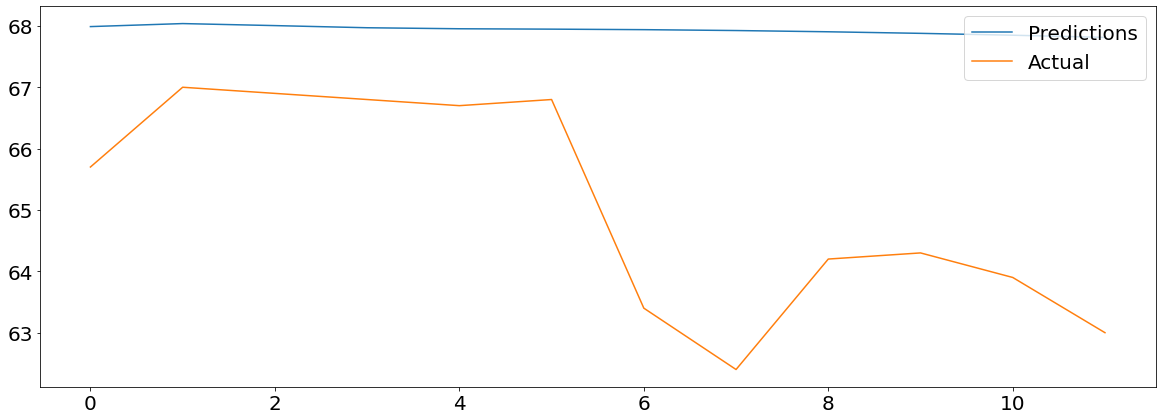

In [113]:
plt.figure(figsize=(20,7))
index_to_plot = 815440
plt.plot(y_pred[index_to_plot,:,0]*std + avg)
plt.plot(y_true[index_to_plot,:,0])
plt.legend(['Predictions', 'Actual'], loc='upper right')
plt.rcParams.update({'font.size': 20})

In [71]:
avg

tensor(64.3560, dtype=torch.float64)

In [72]:
std

tensor(7.2992, dtype=torch.float64)

In [80]:
for i in range(12):
    mae_error_unscaled = float(masked_mae_loss(y_pred[:,i,:]*float(std) + float(avg), 
                                             y_true[:,i,:]))
    
    print('Horizon {}: Masked Test MAE {}'.format(i+1, mae_error_unscaled))
    
all_mae_error_unscaled = float(masked_mae_loss(y_pred[:,:,:]*float(std) + float(avg), 
                                             y_true[:,:,:]))
print('\nAll Horizons: Masked Test MAE {}'.format(all_mae_error_unscaled))

Horizon 1: Masked Test MAE 5.0995388331374345
Horizon 2: Masked Test MAE 5.0579578678748485
Horizon 3: Masked Test MAE 5.019533339177299
Horizon 4: Masked Test MAE 4.990011298402474
Horizon 5: Masked Test MAE 4.96433185337184
Horizon 6: Masked Test MAE 4.942106818422962
Horizon 7: Masked Test MAE 4.9208840723452525
Horizon 8: Masked Test MAE 4.899465113024581
Horizon 9: Masked Test MAE 4.8781607596499965
Horizon 10: Masked Test MAE 4.857346550545522
Horizon 11: Masked Test MAE 4.837240495193904
Horizon 12: Masked Test MAE 4.818158971435442

All Horizons: Masked Test MAE 4.940394664381796


In [88]:
y_true = c_time_series[:training_size,pred_size:,:]
y_pred = torch.reshape(torch.tensor(preds_train), (8309140, 12, 1))*float(c_time_series.std()) + float(c_time_series.mean())

masked_mae_loss(y_pred, y_true)

tensor(1.5686, dtype=torch.float64)